#### Goal: Simulate a vrms map with Jampy axi rms.

For this, we are using a MGE light decomposition of SDP.81 (already in proper units, and stored in JAM_Input.txt).

Beside that, we include a pseudo-NFW profile for dark matter (stored in pseudo-NFW.txt with intensity equal to one, but we change it during the simulation).

We are using a MUSE psf.

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from plotbin.plot_velfield import plot_velfield
from My_Jampy import JAM                          #My class for jampy

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens_tests/autolens_workspace/Simulation_with_DM/Simulation_data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("pseudo-NFW.txt", unpack=True)     #DM component
norm_psf, sigma_psf           = np.loadtxt("MUSE_Psf_model.txt", unpack=True) #PSF

### Input parameters

In [236]:
z_l    = 0.299                                            #Redshift
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
beta   = np.array([-0.6, -2.5, -0.4, -1.5, 0.39, -0.32, 0.36, -1.36])  #anisotropy [ad]
inc    = 77                                                            #inclination [deg]
dm_int = 0.05 * (10**10)                                               #Intensity of DM (~ 20% of lum_mass)
ml     = np.array([6, 4.5, 4, 3.5, 3, 2.5, 2, 1])                      #mass to light ratio

pixsize = 0.2    #MUSE pixel size


In [231]:
#Grid with xbin and ybin position (in px)
np.random.seed(123)
xbin, ybin = np.random.uniform(low=[-25, -20], high=[25, 20], size=[300, 2]).T

r = np.sqrt(xbin**2 + (ybin/np.cos(np.radians(inc)))**2) # Radius in the plane of the disk
goodbins = r > 5  # Arbitrarily exclude the center to illustrate how to use goodbins

In [232]:
#Now we start our Jampy class
Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc, distance=D_l, mbh=mbh, beta=beta,
                   normpsf=norm_psf, sigmapsf=sigma_psf, pixsize=pixsize, goodbins=goodbins)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)
#Add DM component
Jam_model.DM_component(surf_dm=dm_int * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [233]:
#Run my Jam class
plt.figure(figsize=(12,12))
My_model, ml = Jam_model.run_simulation(plot=True, quiet=False, cmap="sauron",nodots=False)


jam_axi_rms elapsed time sec: 0.93


/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: divide by zero encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')
/home/carlos/anaconda3/lib/python3.7/site-packages/jampy/legacy/jam_axi_rms.py:281: RuntimeWarning: invalid value encountered in true_divide
  / signal.fftconvolve(mgeCar, kernel, mode='same')


<Figure size 864x864 with 0 Axes>

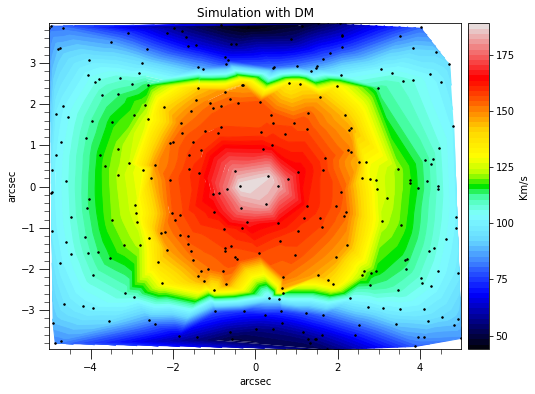

In [234]:
plt.figure(figsize=(8,6))
plot_velfield(x=xbin*pixsize, y=ybin*pixsize, vel=My_model, colorbar=True, label="Km/s")
plt.title("Simulation with DM")
plt.xlabel("arcsec")
plt.ylabel("arcsec")


plt.savefig(data_folder+"Vrms_Map.png", fmt="png")

In [235]:
vrsm_data = np.savetxt(data_folder+"vrms_data.txt", np.column_stack([xbin, ybin, My_model]),
                          fmt=b'%.5e \t %.5e \t %.5e', 
                            header="xbin [px] \t ybin [px] \t vrms [Km/s]")